# TMDB Box Office Prediction
This kernel is made for Kaggle competition called TMDB Box Office Prediction.

The main goal is to predict overall worldwide box office revenue from films by exploring metadata on over 7,000 past films from The Movie Database (https://www.themoviedb.org/) and building Machine Learning models. 

This kernel presents one of the possible solutions.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error

### Load CSV files with the data

In [2]:
trainFrame = pd.read_csv('../input/train.csv')
testFrame = pd.read_csv('../input/test.csv')

### Look at the head of the data

In [3]:
print(trainFrame.head())

   id    ...      revenue
0   1    ...     12314651
1   2    ...     95149435
2   3    ...     13092000
3   4    ...     16000000
4   5    ...      3923970

[5 rows x 23 columns]


In [4]:
print(testFrame.head())

     id                        ...                                                                       crew
0  3001                        ...                          [{'credit_id': '52fe44e7c3a368484e03d683', 'de...
1  3002                        ...                          [{'credit_id': '55807805c3a3685b1300060b', 'de...
2  3003                        ...                          [{'credit_id': '52fe4330c3a36847f8041367', 'de...
3  3004                        ...                          [{'credit_id': '56478092c3a36826140043af', 'de...
4  3005                        ...                          [{'credit_id': '52fe44ce9251416c75041967', 'de...

[5 rows x 22 columns]


### Look at the shapes of the data

In [5]:
print(trainFrame.shape, testFrame.shape)

(3000, 23) (4398, 22)


### Look at the columns and number of not null values

In [6]:
print(trainFrame.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [7]:
print(testFrame.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

### Fill in missing values 
Fill numeric with mean, text with 0.

In [8]:
trainFrame = trainFrame.fillna(trainFrame.mean())
testFrame = testFrame.fillna(testFrame.mean())
trainFrame = trainFrame.fillna(0)
testFrame = testFrame.fillna(0)

### Create function for searching unic genres
Feature 'genres' contains genres in list of dicts in one cell. We use json for extracting them.

In [9]:
def findGenres(DataFrame):
    #creating set of unic genres
    unicGenres = set()    
    for i in range(DataFrame.shape[0]):
        jsonGenres = json.loads(str(DataFrame.loc[i, ('genres')]).replace('\'','"'))
        
        if jsonGenres != 0:    
            for elem in jsonGenres:
                genreName = elem.get('name')
                unicGenres.add(genreName)
                
    return unicGenres

### Search unic genres

In [10]:
unicGenres = findGenres(trainFrame)
print(unicGenres)

{'Documentary', 'Comedy', 'Music', 'Animation', 'Science Fiction', 'Mystery', 'Western', 'Romance', 'Foreign', 'Adventure', 'History', 'Action', 'Crime', 'War', 'TV Movie', 'Thriller', 'Family', 'Fantasy', 'Drama', 'Horror'}


### Create function for adding features
In this function we add new features to DataFrame and calculate number of films by genres. Features:
- for every genre we add 1 feature with name of genre. Value will be 1 if genre exists and 0 if it doesn't,
- we add new feature 'year' which will contain year of feature 'release_date'. The problem is that 'release_date' contains dates in dd/mm/yy format where the year has only 2 symbols.

In [11]:
def addGenres(DataFrame, unicGenres):
    #add new feature for every genre
    for gentre in unicGenres:
        DataFrame.loc[:, gentre] = 0

    #update values of genres
    for i in range(DataFrame.shape[0]):
        jsonGenres = json.loads(str(DataFrame.loc[i, ('genres')]).replace('\'','"'))

        if jsonGenres != 0:    
            for elem in jsonGenres:
                genreName = elem.get('name')

                if genreName in unicGenres:
                    DataFrame.loc[i, (genreName)] = 1

        #add feature 'year'
        year = ''
        if DataFrame.loc[i, 'release_date'] == 0:
            year = 0
        else:
            yearSlice = str(DataFrame.loc[i, 'release_date'])[-2:]
            if yearSlice[0] == '0':
                year = '200' + yearSlice[1]
            if int(yearSlice) < 20:
                year = '20' + yearSlice
            else:
                year = '19' + yearSlice
        DataFrame.loc[i, 'year'] = year

    #calculate number of films by genres
    countGenres = []
    for elem in unicGenres:
        countGenres.append([elem, len(DataFrame.loc[DataFrame[elem]>0])])
    DataFrame.loc[:,'year'] = DataFrame.loc[:,'year'].apply(int)
    DataFrame = DataFrame.drop(columns=['genres'], axis=1)
    DataFrame = DataFrame.sort_index(axis=1)
    
    return DataFrame, countGenres

### Add features and calculate number of films by genres

In [12]:
trainFrame, countGenres1 = addGenres(trainFrame, unicGenres)
testFrame, countGenres2 = addGenres(testFrame, unicGenres)
print(countGenres1)

[['Documentary', 87], ['Comedy', 1028], ['Music', 100], ['Animation', 141], ['Science Fiction', 290], ['Mystery', 225], ['Western', 43], ['Romance', 571], ['Foreign', 31], ['Adventure', 439], ['History', 132], ['Action', 741], ['Crime', 469], ['War', 100], ['TV Movie', 1], ['Thriller', 789], ['Family', 260], ['Fantasy', 232], ['Drama', 1531], ['Horror', 301]]


### Plot the graph of the number of films sorted by genres

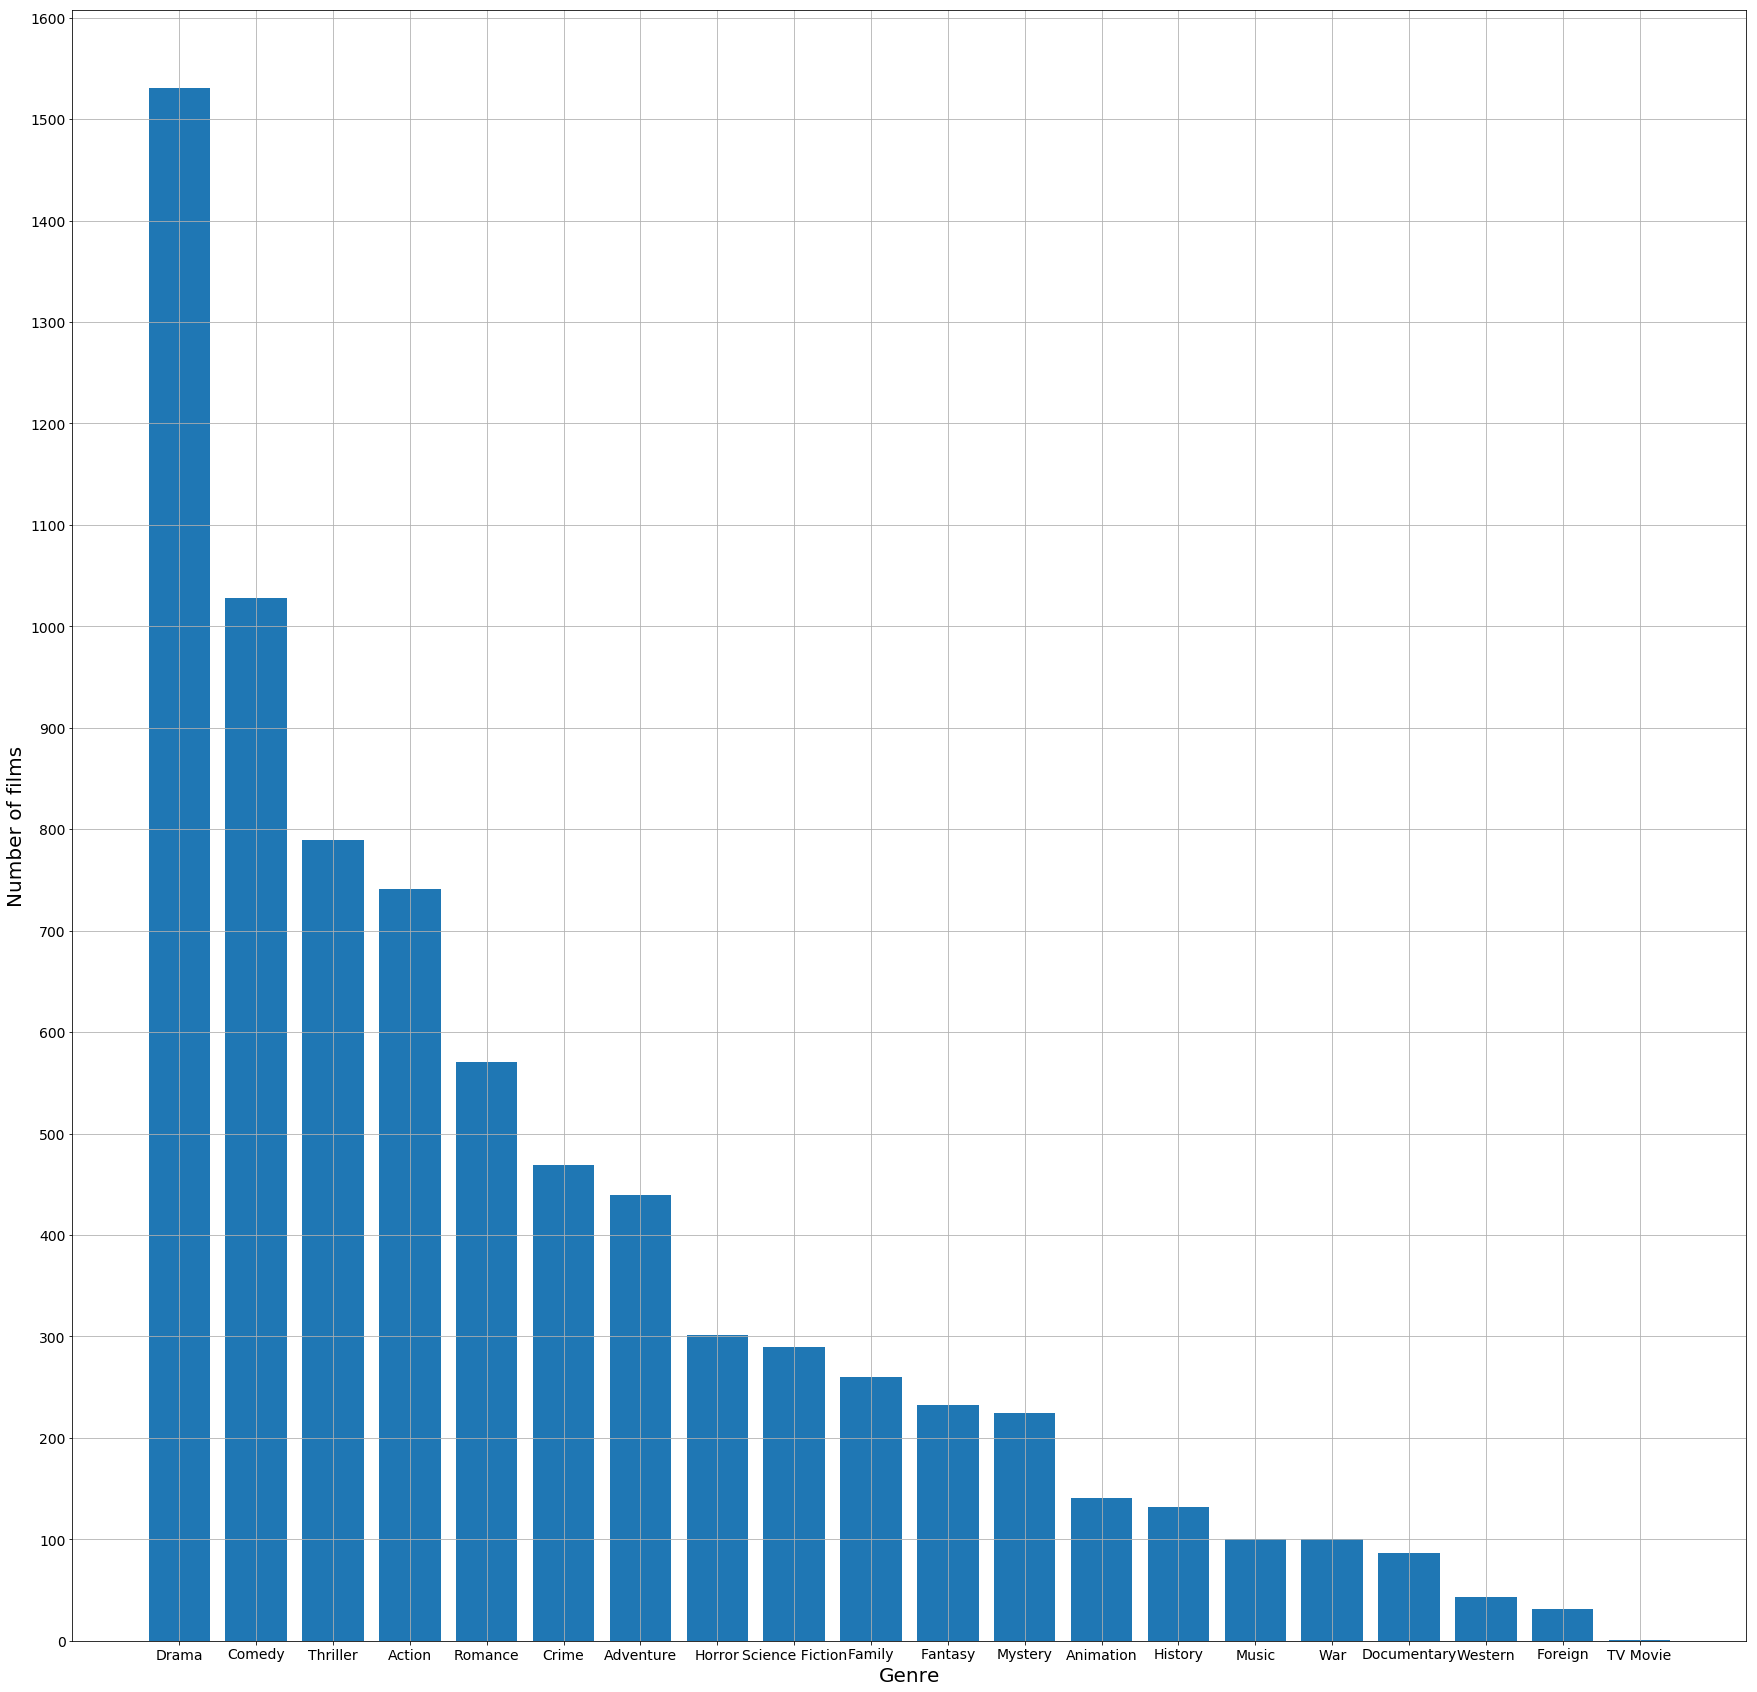

In [13]:
countGenres1.sort(key=lambda x: x[1], reverse=True)
x1 = []
y1 = []
for elem in countGenres1:
    x1.append(elem[0])
    y1.append(elem[1])
plt.figure(1, figsize=(30, 30))
plt.xlabel('Genre', fontsize=20)
plt.ylabel('Number of films', fontsize=20)
plt.yticks(np.arange(0, 1700, step=100))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
plt.bar(x1, y1)
plt.show()

### Look at some numeric features

In [14]:
trainFrame[['revenue', 'popularity', 'runtime', 'budget']].describe()

,revenue,popularity,runtime,budget
count,3.000000e+03,3000.000000,3000.000000,3.000000e+03
mean,6.672585e+07,8.463274,107.856571,2.253133e+07
std,1.375323e+08,12.104000,22.079069,3.702609e+07
min,1.000000e+00,0.000001,0.000000,0.000000e+00
25%,2.379808e+06,4.018053,94.000000,0.000000e+00
50%,1.680707e+07,7.374861,104.000000,8.000000e+06
75%,6.891920e+07,10.890983,118.000000,2.900000e+07
max,1.519558e+09,294.337037,338.000000,3.800000e+08


### Plot histograms of some numeric features

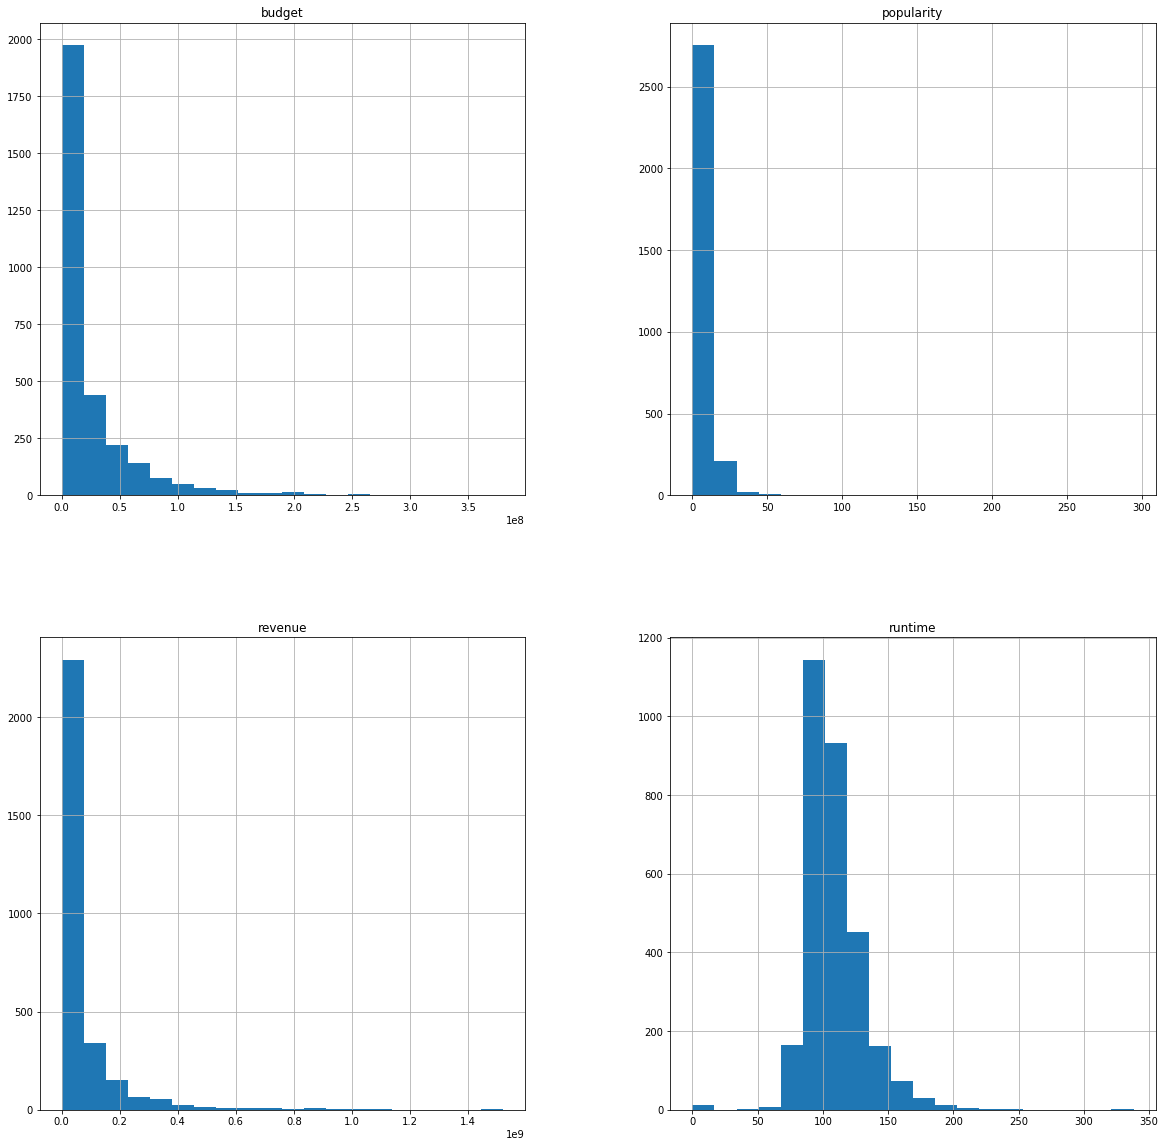

In [15]:
trainFrame[['revenue', 'popularity', 'runtime', 'budget']].hist(figsize=[20,20], bins=20)
plt.show()

### Plot the graph showing Revenue for each year

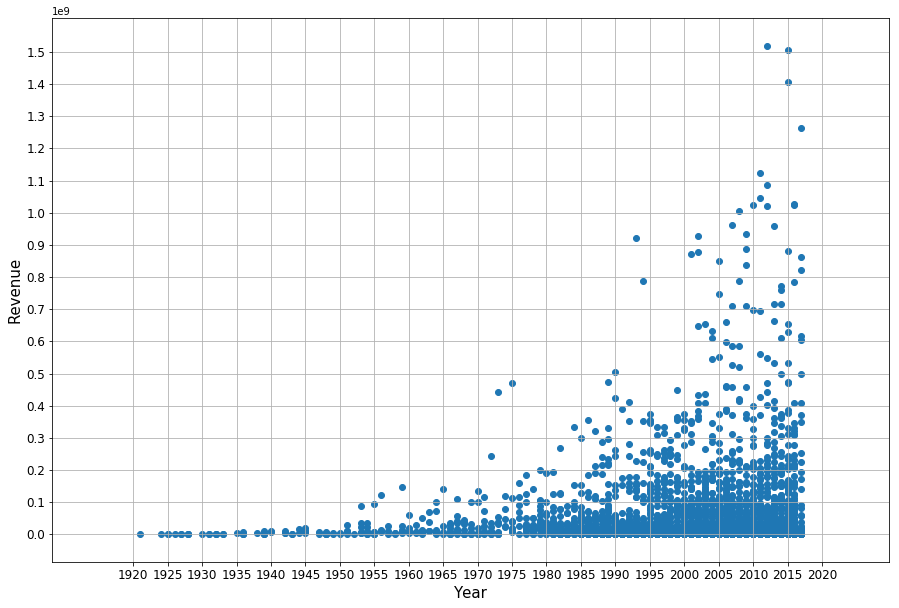

In [16]:
plt.figure(1, figsize=(15, 10))
plt.xlabel('Year', fontsize=15)
plt.ylabel('Revenue', fontsize=15)
plt.xticks(np.arange(1920, 2025, step=5))
plt.yticks(np.arange(0, 1.6*10**9, step=100000000))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.scatter(trainFrame['year'], trainFrame['revenue'])
plt.show()

### Plot the graph showing number of films for each year

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Series.data is deprecated and will be removed in a future version
  if sys.path[0] == '':


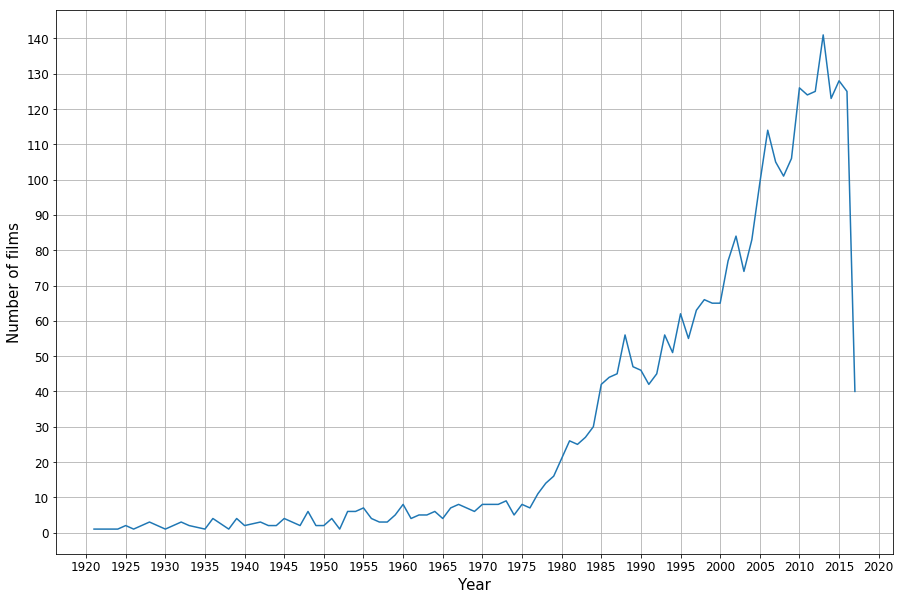

In [17]:
countByYears = trainFrame['year'].value_counts().sort_index(ascending=False)

plt.figure(1, figsize=(15, 10))

plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of films', fontsize=15)

plt.xticks(np.arange(1920, 2025, step=5))
plt.yticks(np.arange(0, 150, step=10))
plt.tick_params(axis='both', which='major', labelsize=12)

plt.plot(countByYears.index, countByYears.data)
plt.grid(True)
plt.show()

### Look at the correlation of features

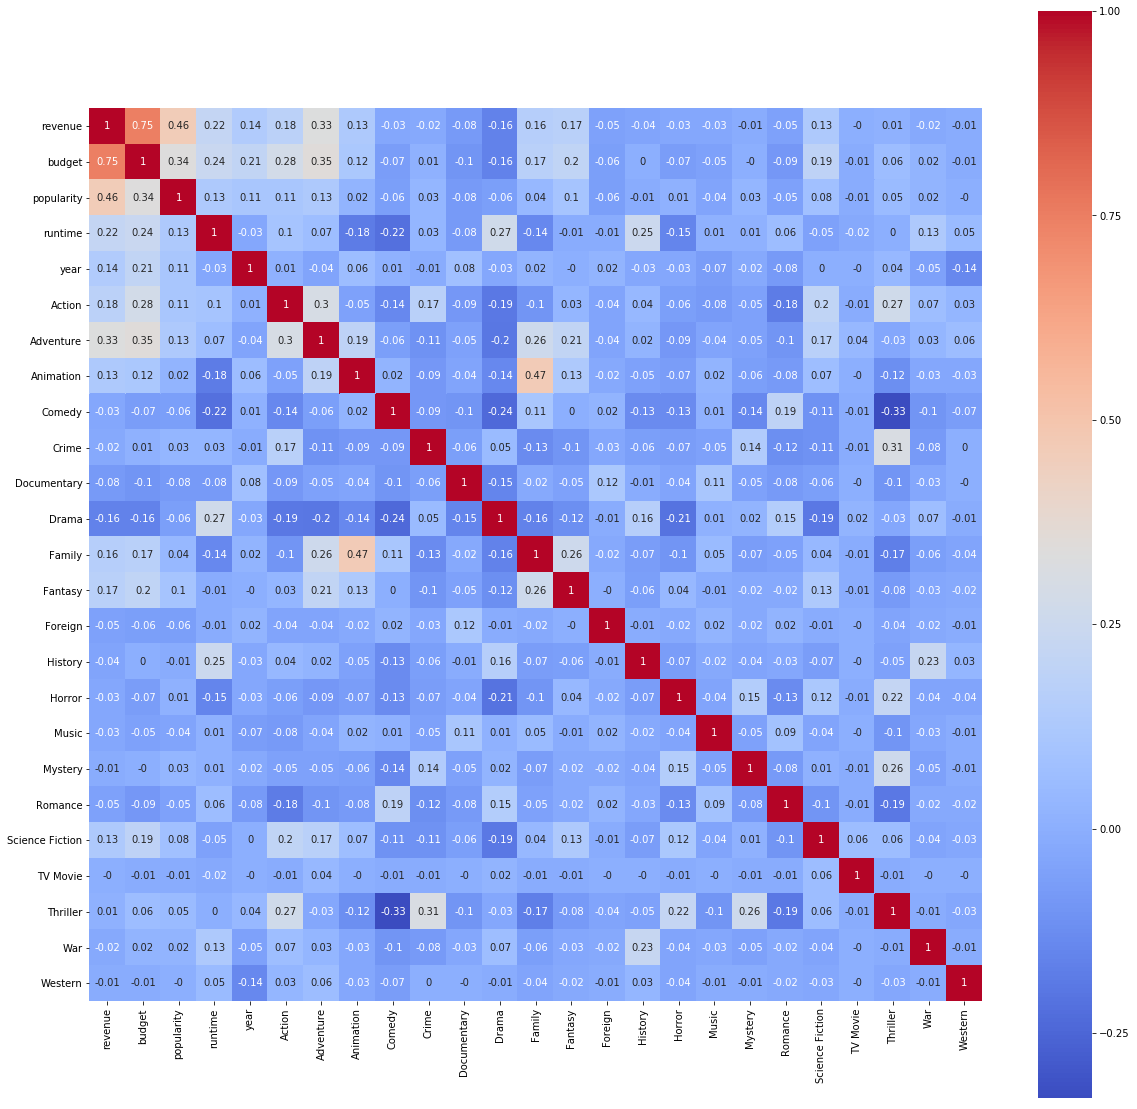

In [18]:
#find correlations
corrMatrix = trainFrame[['revenue', 'budget', 'popularity', 'runtime', 'year', 'Action', 'Adventure', 
                         'Animation', 'Comedy', 'Crime','Documentary', 'Drama', 'Family', 'Fantasy', 
                         'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 
                         'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']].corr()

#plot heatmap for correlations
plt.figure(figsize=(20, 20))
sns.heatmap(round(corrMatrix, 2), annot=True, square=True, cmap='coolwarm')
plt.show()

### Plot the graph of the revenue dependence on budget

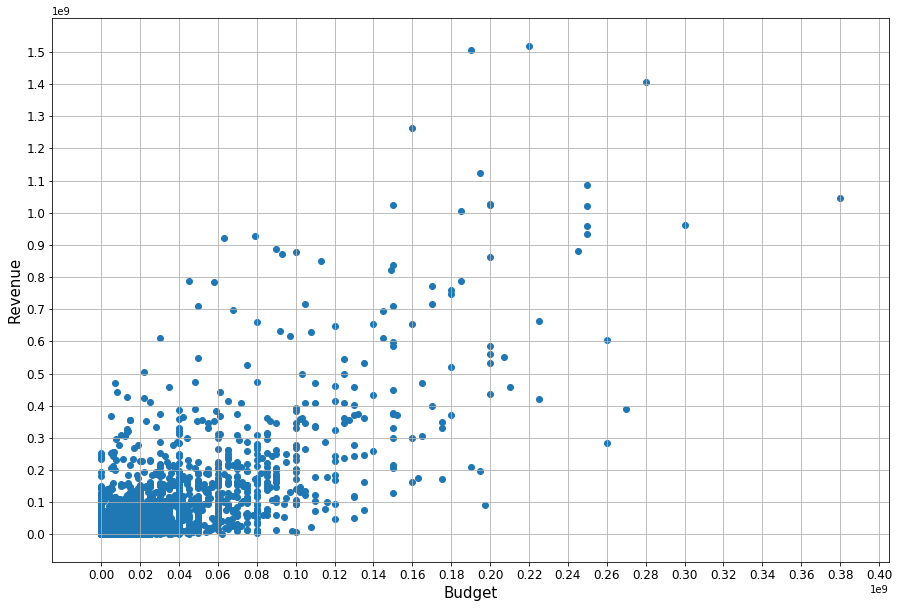

In [19]:
plt.figure(1, figsize=(15, 10))
plt.xlabel('Budget', fontsize=15)
plt.ylabel('Revenue', fontsize=15)
plt.xticks(np.arange(0, 1.6*10**9, step=20000000))
plt.yticks(np.arange(0, 1.6*10**9, step=100000000))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.scatter(trainFrame['budget'], trainFrame['revenue'])
plt.show()

### Choose data for the model

In [20]:
#shuffle train data
trainFrame = shuffle(trainFrame, random_state=105)

#choose some features highly correlated with target variable
X = trainFrame[['budget', 'year', 'popularity', 'runtime', 'Adventure', 'Action']].values
y = np.ravel(trainFrame['revenue'].values)

predictData = testFrame[['budget', 'year', 'popularity', 'runtime', 'Adventure', 'Action']].values
predictDataId = np.ravel(testFrame['id'].values)


### Build a model
We choose KNeighborsRegressor model because it's simple and good when we have not much data.

In [21]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=77)

#make pipeline containing Scaler and KNeighborsRegressor model 
pipe = make_pipeline(StandardScaler(), KNeighborsRegressor())

#use GridSearchCV for finding best model parameters
param_grid = {'kneighborsregressor__n_neighbors': [x+1 for x in range(10)]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='neg_mean_squared_log_error')
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Score Train:", grid.score(X_train, y_train))
print('Score Test:', grid.score(X_test, y_test))

#compute RMSE
y_pred = grid.predict(X_test)

mse = mean_squared_log_error(y_test, y_pred)
rmse = sqrt(mse)
print('MSE:', mse)
print('RMSE:', rmse)

#predict data
predictions = grid.predict(predictData)


Best Params: {'kneighborsregressor__n_neighbors': 4}
Score Train: -5.652391324418927
Score Test: -6.004552241890898
MSE: 6.004552241890898
RMSE: 2.45041878908298


### Write predicted data in CSV

In [22]:
EndFrame = pd.DataFrame(columns=['id', 'revenue'])
for i in range(len(predictions)):
    EndFrame = EndFrame.append({'id': int(predictDataId[i]), 
                                'revenue': predictions[i]}, 
                                ignore_index=True)

EndFrame.loc[:,('id')] = EndFrame.loc[:,('id')].apply(int)
EndFrame.to_csv('submission.csv', index=False)

### Conclusion
We have made some analysis of data and built Machine Learning model which can predict revenue of films.
But there is more space for improving quality of predictions. For doing this we can extract more features from data (like we did with features of genres and 'year') and try other algorithms.